# 'Recommendation of similar articles from journal abstract analysis'  
# Modeling for recommendation creation
## 2019, Misty M. Giles
### https://github.com/OhThatMisty/astro_categories/

In [1]:
%matplotlib inline

from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_short
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import spacy
import unicodedata

plt.style.use('fivethirtyeight')

C:\Users\Misty\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\Misty\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
def normalize(text):
    '''Convert to ascii, remove special characters associated with LaTeX when given a df column,
       only keep alpha chars'''
    normalized_text = []
    
    for t in text:
        t = unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower()
        # This pair is necessary to separate some words because of the LaTeX/mathtext formatting 
        t = re.sub('mathrm|gtrsim|lesssim|odot|langle', ' ', t)
        t = re.sub('rangle|rm off|\\\\\S*|\$\S*\$|\set[\. ]+al[\. ]+', ' ', t) 
        # Collapse terms like x-ray that are disappearing
        t = re.sub(r'\bx-\b', 'x_', t)
        # Remove everthing but alpha, underscores
        t = re.sub('[^a-zA-Z_]+', ' ', remove_stopwords(t))
        # strip_short gets rid of the rest of the math leftovers
        normalized_text.append(strip_short(t, minsize=2))
    return normalized_text

# This function is to remove excess whitespace 
def remove(token):
    '''Provide feedback on whether a token is excess whitespace'''
    return token.is_space or token.is_digit

# This function ensures that all printouts use the same formula
def join_tokens(sent):
    '''Joins tokens in a sent without whatever is in remove(), adds pronoun back
       in instead of -PRON-'''
    return ' '.join([token.lemma_ if token.lemma_ != '-PRON-' else token.text.lower()
                     for token in sent if not remove(token)])

# This function prevents nested lists that kill the vectorizer
def join_sentences(doc):
    '''Joins sentences in a doc (includes join_tokens)'''
    return ' '.join([join_tokens(sent) for sent in doc.sents])

# Set up spacy to lemmatize the text
nlp = spacy.load('en', disable=['ner'])

###  Change the "docs_to_run" variable in this box to reflect testing/full run.

In [3]:
# Get the csv file created in the cleaning notebook
file = os.path.join('..', 'data', 'astro_intermediate.csv')
df = pd.read_csv(file, index_col=0)
# Shuffle the df so that all times available are represented in both test and train
df = df.sample(frac=1).reset_index(drop=True)

# Set variables for testing speed
docs_to_run = len(df)  # 1000 for testing, len(df) for real processing
train_docs = int(0.98 * docs_to_run)  # 98% training, 2% test
test_docs = docs_to_run - train_docs
print('Setting up to train on', train_docs, 'abstracts.')
print('Setting up test block of', test_docs, 'abstracts.')
print('Total', docs_to_run, 'abstracts in session.')

# Set up the sentences_file needed in later steps
sentences_file = os.path.join('..', 'data', 'astro_normalized_premodel.txt')

Setting up to train on 58772 abstracts.
Setting up test block of 1200 abstracts.
Total 59972 abstracts in session.


### For the next three boxes (4, 5, 6):  Box 4 will take quite awhile to run.  Box 5 writes the result of box 4 to a text file.  Box 6 will stream the text file back into the notebook or recreate the variable "text" that can be used in the rest of the notebook without any more changes.  Box 6 will need to be altered depending on your purpose. 

In [4]:
%%time

# This is the long box - 1h on quad-core, 8G RAM machine.  If you already have the sentences_file
# saved, you can ignore these two boxes and make any alterations you need to in the following box.

# Clean the file (remove punctuation, lowercase, lemmatize, remove 1-char objects --
# most are math/LaTeX formatting leftovers or possessives)
text = [join_sentences(doc) for doc in nlp.pipe(normalize(df.abstract[:docs_to_run]), batch_size=50)]

Wall time: 56min 20s


In [5]:
# Ignore this box if using the sentences_file from GitHub.

# Create a filepath and write out the sentences, removing stopwords to save space on GitHub.
with open(sentences_file, 'w') as out_file:
     for sent in text:
            out_file.write(remove_stopwords(sent) + '\n')

In [6]:
# This is the box where you might need some edits if using the sentences_file.  If you are, 
# results might slightly vary.

# Code for printing out an article from the text file to test it.  Can be used to stream
# if you use the iterator method.

# Iterator method (uncomment all three lines):
#sentences = open(sentences_file, 'r')
#for i, line in enumerate(sentences):
#    if i == 10980: print(line)
        
# Recreate the variable "text" (uncomment 1st, 2nd, 4th):
#with open(sentences_file, 'r') as in_file:
#    text = list(in_file)
# Test that "text" recreated appropriately (printout should be a list with string: ['lots of words'])
#text[10980:10981]

In [7]:
print('Sample abstract to demonstrate cleaning (or verify good import):\n')
print(text[0:1])

Sample abstract to demonstrate cleaning (or verify good import):

['analyze inspiral dynamic equal mass precess black hole binari multi timescale technique orbit average post newtonian evolutionary equation admit constant motion equal mass limit magnitude total spin effective spin feature make entire dynamic qualitatively different compare generic unequal mass case constant variable parametriz precession dynamic fix individual mass spin magnitude equal mass black hole inspiral uniquely characterize parameter number completely determine entire evolution effect radiation reaction particular equal mass binary black hole binary spin morphology constant inspiral ii precessional motion black hole spin total spin take place long timescale precession total spin orbital plane total angular momentum']


### Model: tfidf using sklearn

In [8]:
%%time

# Set up the model for vectorizing/calculating the similarity; words must appear 
# in at least 400 documents.   
tfidf = TfidfVectorizer(ngram_range=(1,3), min_df=400)

# Transform/fit the training and test data to the model
tfidf_matrix = tfidf.fit_transform(text[:train_docs]).todense()
article_matrix = tfidf.transform(text[train_docs:]).todense()

# Create a df of the model's values
tfidf_df = pd.DataFrame(tfidf_matrix, columns=tfidf.get_feature_names())
article_df = pd.DataFrame(article_matrix, columns=tfidf.get_feature_names())

Wall time: 1min 30s


In [9]:
print('Training vocabulary:', len(tfidf.get_feature_names()))
print('Stopwords:', len(tfidf.stop_words_))

Training vocabulary: 2288
Stopwords: 7041547


In [10]:
# Remove the stopwords to free up some memory
delattr(tfidf, 'stop_words_')

###  Now that the model has been prepared, it's time to choose a sample abstract from the test set.  This is a proof-of-concept method for a recommendation engine that suggests articles based on the abstract you're reading.  As it's proof-of-concept, the abstract will be randomly chosen for you from the test abstracts.  (Abstract and highest-rated related abstract shown at bottom of notebook.)

In [46]:
# Pick an article to function as the sample 
article_idx = np.random.randint(0, test_docs)

# Uncomment the line below if you want to see the cleaned data from the new sample
#text[article_idx+train_docs:article_idx+train_docs+1]

#### Finding recommendations from tfidf and cosine similarity, using the sample abstract above.

In [47]:
# Compute the document similarities with sklearn linear_kernel.  Per sklearn,
# linear_kernal is faster than cosine_similarity for tfidf.
document_similarity = linear_kernel(article_df.iloc[article_idx:article_idx+1], tfidf_df).flatten()

# Get the indices for the documents that have highest cosine similarity to the sample.
related_indices = document_similarity.argsort()[:-7:-1]
related_indices

array([ 3982, 12773,  7627, 22505, 34568, 29099], dtype=int64)

In [48]:
# Create a df with the attributes of the similar documents
related_abstracts = df[['abstract', 'title', 'terms']].iloc[related_indices]
related_abstracts['document_similarity'] = document_similarity[related_indices]

# Print out the most similar documents
related_abstracts

,abstract,title,terms,document_similarity
3982,Recent work indicates that the nearby Galactic...,The origin of accreted stellar halo population...,astro-ph.GA,0.586823
12773,Based on the [Fe/H] versus [Mg/Fe] diagram and...,A Hint of Three-section Halo as Seen from the ...,astro-ph.GA|astro-ph.SR,0.584911
7627,According to the current cosmological cold dar...,Are ancient dwarf satellites the building bloc...,astro-ph.GA,0.552120
22505,From exploratory studies and theoretical expec...,Non-local thermodynamic equilibrium stellar sp...,astro-ph.SR,0.543964
34568,We present the non-local thermodynamic equilib...,Influence of Inelastic Collisions with Hydroge...,astro-ph.SR,0.543791
29099,We explore the hypothesis that the classical a...,The connection between the Galactic halo and a...,astro-ph.GA,0.535392


### How much does the first result have in common with the sample?  This table (sorted by feature importance of the sample article) shows how many and which of the top features match up.

In [49]:
# Get the features of the sample article
sample_features = dict(article_df.iloc[article_idx])
sample_features = pd.DataFrame.from_dict(sample_features, orient='index').reset_index()
sample_features.columns = ['feature', 'sample_importance']
# Get the features for the highest-ranked related article
related_features = dict(tfidf_df.iloc[related_indices[0]])
related_features = pd.DataFrame.from_dict(related_features, orient='index').reset_index()
related_features.columns = ['feature', 'related_importance']
# Concat dfs
features_df = sample_features.merge(related_features, on='feature')
features_df.loc[features_df.sample_importance > 0].sort_values(by='sample_importance', ascending=False)[:10]

,feature,sample_importance,related_importance
750,fe,0.596064,0.549699
1986,star,0.243527,0.205334
2163,trend,0.230708,0.056737
899,halo,0.189803,0.140031
1059,intermediate,0.149797,0.000000
1810,satellite,0.144294,0.106456
406,contribution,0.135340,0.000000
1430,observe,0.127721,0.031410
1471,origin,0.127427,0.000000
716,explore,0.126255,0.000000


### But what features were most important for the highly ranked article?

In [50]:
related_features.sort_values(by='related_importance', ascending=False)[:5]

,feature,related_importance
750,fe,0.549699
1283,mg,0.269625
1986,star,0.205334
924,high,0.201642
19,accretion,0.175742


##### Here are the full, unaltered abstracts from the sample and the highest-rated related article.

In [51]:
# Get the abstract for the sample article
# Abstract is unaltered from download (more human-readable but includes formatting).
print('ABSTRACT TO MATCH: \n', df.url.iloc[(article_idx + train_docs)], '\n')
print(df.title.iloc[(article_idx + train_docs)], '\n')
print(df.abstract.iloc[(article_idx + train_docs)], '\n')
print(df.terms.iloc[(article_idx + train_docs)])

ABSTRACT TO MATCH: 
 http://arxiv.org/abs/1809.02368v2 

The assembly history of the Galactic inner halo inferred from   alpha-patterns 

We explore the origin of the observed decline in [O/Fe] (and [Mg/Fe]) with Galactocentric distance for high-metallicity stars ([Fe/H] > -1.1), based on a sample of halo stars selected within the Apache Point Observatory Galactic Evolution Experiment (APOGEE) fourteenth data release (DR14). We also analyse the characteristics of the [$\alpha$/Fe] distributions in the inner-halo regions inferred from two zoom-in Milky Way mass-sized galaxies that are taken as case studies. One of them qualitatively reproduces the observed trend to have higher fraction of $\alpha$-rich star for decreasing galactocentric distance; the other exhibits the opposite trend. We find that stars with [Fe/H] > -1.1 located in the range [15 - 30] kpc are consistent with formation in two starbursts, with maxima separated by about ~ 1 Gyr. We explore the contributions of stellar pop

In [52]:
# Get the abstract for the highest-ranked related article
# Abstract is unaltered from download (more human-readable but includes formatting).
print('HIGHEST-RATED MATCH \n', df.url.iloc[related_indices[0]], '\n')
print(df.title[related_indices[0]], '\n')
print(df.abstract[related_indices[0]], '\n')
print(df.terms[related_indices[0]])

HIGHEST-RATED MATCH 
 http://arxiv.org/abs/1808.00968v2 

The origin of accreted stellar halo populations in the Milky Way using   APOGEE, $\textit{Gaia}$, and the EAGLE simulations 

Recent work indicates that the nearby Galactic halo is dominated by the debris from a major accretion event. We confirm that result from an analysis of APOGEE-DR14 element abundances and $\textit{Gaia}$-DR2 kinematics of halo stars. We show that $\sim$2/3 of nearby halo stars have high orbital eccentricities ($e \gtrsim 0.8$), and abundance patterns typical of massive Milky Way dwarf galaxy satellites today, characterised by relatively low [Fe/H], [Mg/Fe], [Al/Fe], and [Ni/Fe]. The trend followed by high $e$ stars in the [Mg/Fe]-[Fe/H] plane shows a change of slope at [Fe/H]$\sim-1.3$, which is also typical of stellar populations from relatively massive dwarf galaxies. Low $e$ stars exhibit no such change of slope within the observed [Fe/H] range and show slightly higher abundances of Mg, Al and Ni. Unlik

### Now plots.

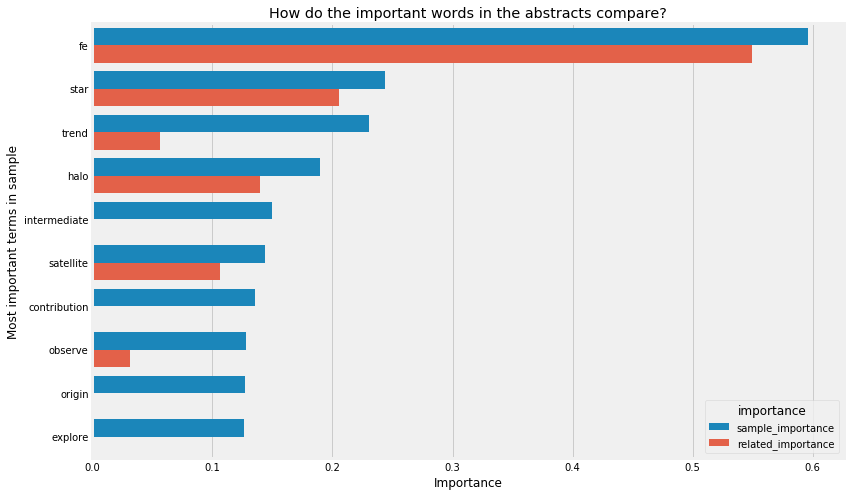

In [81]:
data = features_df.loc[features_df.sample_importance > 0].sort_values(by='sample_importance', ascending=False)[:10]
tidy = data.melt(id_vars='feature').rename(columns=str.lower)
tidy.columns = ['feature', 'importance', 'value']
_ = plt.figure(figsize=(12,8))
_ = sns.barplot(x='value', y='feature', hue='importance', data=tidy)
_ = plt.xlabel('Importance')
_ = plt.ylabel('Most important terms in sample')
_ = plt.title('How do the important words in the abstracts compare?')
_ = plt.xticks([0, .05, .1, .15, .2, .25, .3, .35, .])